In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter

%matplotlib widget


In [2]:
s1 = pd.read_csv('set-a-text/a10.csv',skiprows=[0,1],names=['time','channel1','channel2','channel3','channel4'],)
QRSpostions = np.loadtxt('set-a-text/a02.fqrs.txt',dtype=int,)

In [61]:
QRSpostions

array([  307,   656,  1042,  1416,  1794,  2163,  2542,  2912,  3289,
        3667,  4043,  4409,  4785,  5170,  5544,  5906,  6281,  6670,
        7044,  7404,  7777,  8168,  8545,  8903,  9272,  9663, 10045,
       10402, 10767, 11158, 11544, 11901, 12261, 12653, 13042, 13398,
       13755, 14148, 14539, 14893, 15249, 15644, 16034, 16386, 16744,
       17140, 17528, 17880, 18241, 18636, 19021, 19375, 19739, 20133,
       20515, 20871, 21238, 21630, 22010, 22368, 22737, 23128, 23506,
       23865, 24236, 24626, 25003, 25362, 25735, 26125, 26499, 26860,
       27235, 27623, 27996, 28359, 28735, 29120, 29493, 29859, 30236,
       30617, 30991, 31360, 31736, 32115, 32490, 32861, 33235, 33612,
       33990, 34362, 34734, 35111, 35490, 35862, 36232, 36609, 36990,
       37362, 37730, 38107, 38490, 38862, 39228, 39606, 39990, 40361,
       40727, 41104, 41488, 41860, 42226, 42604, 42987, 43358, 43725,
       44104, 44486, 44855, 45224, 45606, 45984, 46351, 46725, 47107,
       47481, 47848,

In [33]:
s1.head()

,time,channel1,channel2,channel3,channel4
0,0.000,7.4,23.400,-5.5,-5.0
1,0.001,7.6,20.900,-5.1,-5.1
2,0.002,7.8,18.000,-4.6,-5.6
3,0.003,7.8,14.800,-4.1,-5.8
4,0.004,7.8,11.300,-3.6,-5.3


In [3]:
def clean_data(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and clean it by removing the NaN values and convert the values to numeric.
    """
    for i in fecg_df.columns:
        fecg_df[i] = pd.to_numeric(fecg_df[i], errors='coerce').fillna(0)
    return fecg_df

In [4]:
s1 = clean_data(s1)

In [5]:
def plot_filter_response(freq,freq_resp):
    """
    Plot the magnitude and phase response of the filter.
    """
    angles = np.unwrap(np.angle(freq_resp))  # Unwrapped phase
    # Magnitude response
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(freq, 20 * np.log10(abs(freq_resp)))
    plt.title('Magnitude Response of the High-Pass FIR Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.xlim([0, 50])  # Match paper's x-axis
    plt.ylim([-40, 10])  # Match paper's y-axis
    plt.grid()

    # Phase response (unwrap to visualize better)
    plt.subplot(1, 2, 2)
    plt.plot(freq, angles, linewidth=1.5)
    plt.title('Phase Response of the High-Pass FIR Filter')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degree)')
    plt.grid()
    plt.xlim([0, 50])
    plt.ylim([-600, 0])  # Limit the y-axis for better visualization
    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt, freqz

def wander_removal(signal, cutoff=3.0, fs=400, num_taps=1001, 
                   plot_filter_coefs=False, plot_filter_resp=False, plot_result=False):
    """
    Apply a high-pass filter to remove baseline wander from the ECG signal.

    :param signal: ECG signal (numpy array)
    :param cutoff: Cut-off frequency (Hz)
    :param fs: Sampling frequency (Hz)
    :param num_taps: Number of taps (filter length, must be odd for FIR filter)
    :param plot_filter_coefs: Plot the filter coefficients
    :param plot_filter_resp: Plot the frequency response of the filter
    :param plot_result: Plot the original and filtered signals

    :return: Filtered signal
    """
    signal = np.asarray(signal, dtype=np.float64)

    # Design the high-pass FIR filter
    filter_taps = firwin(num_taps, cutoff, fs=fs, pass_zero="highpass", window='hamming')

    # Plot the filter coefficients
    if plot_filter_coefs:
        plt.figure()
        plt.plot(filter_taps, '.-')
        plt.xlabel('Index')
        plt.ylabel('Amplitude')
        plt.title(f'High-Pass FIR Filter Coefficients ({num_taps} taps)')
        plt.grid()
        plt.show()

    # Compute frequency response
    freq, freq_resp = freqz(filter_taps, worN=1024, fs=fs)
    
    if plot_filter_resp:
        # Compute filter delay
        delay_samples = (num_taps - 1) / 2  # FIR filter delay
        delay_time = delay_samples / fs  # Convert to seconds
        print(f"Filter Delay: {delay_samples} samples ({delay_time:.4f} sec)")

        # Plot frequency response
        plot_filter_response(freq, freq_resp)

    # Apply zero-phase filtering to avoid phase distortion
    filtered_signal = filtfilt(filter_taps, 1.0, signal)
    

    if plot_result:
        time = np.arange(len(signal)) / fs
        
        plt.figure(figsize=(12, 4))
        plt.plot(time, signal, label="Original Signal")
        plt.plot(time, filtered_signal, label="Filtered Signal", linewidth=1.5)
        plt.title("Signal Before and After High-Pass Filtering")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()
        plt.show()

    return filtered_signal

In [7]:
def baseline_wander_remover(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and apply a high-pass filter to remove the baseline wander.
    """
    dummy_df = fecg_df.copy()
    for i in dummy_df.columns:
        if(i != 'time'):
            dummy_df[i] = wander_removal(dummy_df[i])
    return dummy_df

In [8]:
s2 = baseline_wander_remover(s1)

In [9]:
# check for more than 50Hz noise

def check_noise(signal, fs=400, harmonics=[50, 100, 150, 200]):
    """
    Check for strong frequency components at 50 Hz or its harmonics in the signal.
    :param signal: Input signal
    :param fs: Sampling frequency (Hz)
    :param harmonics: List of harmonics to check (default is [50, 100, 150, 200])
    """
    # Perform FFT
    fft_result = np.fft.fft(signal)
    fft_freq = np.fft.fftfreq(len(signal), d=1/fs)  # Sampling frequency is fs

    # Plot the FFT result
    plt.figure(figsize=(12, 6))
    plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_result)[:len(fft_result)//2])
    plt.title('FFT of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.show()

    # Check for strong frequency components at 50 Hz or its harmonics
    for harmonic in harmonics:
        idx = np.argmin(np.abs(fft_freq - harmonic))
        print(f"Frequency: {fft_freq[idx]:.2f} Hz, Magnitude: {np.abs(fft_result[idx]):.2f}")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirnotch, filtfilt, freqz

def multi_channel_PLIC(signal, powerline_freq=50, fs=400, harmonics=3, plot_response=False):
    """
    Apply multiple notch filters to remove power-line interference and its harmonics.

    :param signal: Input ECG signal (numpy array)
    :param powerline_freq: Power-line frequency (Hz) (default: 50 Hz)
    :param fs: Sampling frequency (Hz) (default: 400 Hz)
    :param harmonics: Number of harmonics to remove (e.g., 3 removes 50, 100, 150 Hz)
    :param quality_factor: Quality factor of the notch filters (default: 30)
    :param plot_response: If True, plots the frequency response of the filter
    :return: Filtered signal
    """
    
    filtered_signal = signal.copy()

    # Plot frequency response setup
    if plot_response:
        plt.figure(figsize=(10, 5))
    
    for i in range(1, harmonics + 1):
        notch_freq = powerline_freq * i  # Compute harmonic frequency
        w0 = notch_freq / (fs / 2)  # Normalize frequency
        if i == 1:
            quality_factor = 20
        else:
            quality_factor = 30
        b, a = iirnotch(w0, quality_factor)

        # Apply notch filter
        filtered_signal = filtfilt(b, a, filtered_signal)

        # Plot frequency response
        if plot_response:
            w, h = freqz(b, a, fs=fs)
            plt.plot(w, 20 * np.log10(abs(h)), label=f'Notch at {notch_freq} Hz')

    if plot_response:
        plt.axvline(powerline_freq, color='r', linestyle='--', label='Fundamental')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.title('Notch Filter Frequency Response')
        plt.legend()
        plt.grid()
        plt.show()

    return filtered_signal

def Multi_Power_line_interference_canceller(fecg_df:pd.DataFrame)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and apply a notch filter to remove the power-line interference.
    """
    dummy = fecg_df.copy()
    for i in dummy.columns:
        if(i != 'time'):
            dummy[i] = multi_channel_PLIC(dummy[i])
    return dummy

def visualize_results(corrupted_signal, cleaned_signal, time):
    """
    Visualizes the original ECG signal, corrupted signal, and cleaned signal.

    Parameters:
        ecg_signal (list): The original clean ECG signal.
        corrupted_signal (list): The corrupted signal (ECG + interference).
        cleaned_signal (list): The interference-free ECG signal.
        time (list): The time vector corresponding to the signal.
    """
    plt.figure(figsize=(12, 8))

    # Plot corrupted signal
    plt.subplot(2, 1, 1)
    plt.plot(time, corrupted_signal, label="Corrupted Signal", color='red')
    plt.title("Corrupted Signal (ECG + Interference)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(np.linspace(time.min(), time.max(), 10))  # Set 10 evenly spaced ticks


    # Plot cleaned ECG signal
    plt.subplot(2, 1, 2)
    plt.plot(time, cleaned_signal, label="Cleaned ECG Signal", color='green')
    plt.title("Cleaned ECG Signal")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xticks(np.linspace(time.min(), time.max(), 10))  # Set 10 evenly spaced ticks


    plt.subplots_adjust(hspace=0.4)
    plt.show()


In [11]:
s3 = Multi_Power_line_interference_canceller(s2)

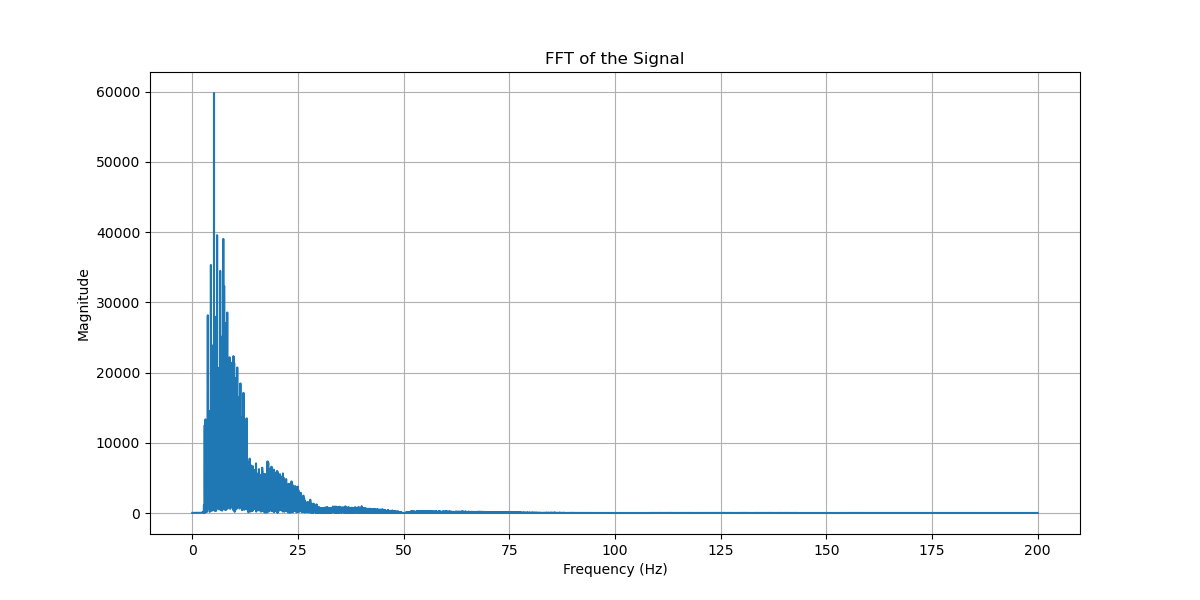

Frequency: 50.00 Hz, Magnitude: 0.67
Frequency: 100.00 Hz, Magnitude: 0.24
Frequency: 150.00 Hz, Magnitude: 0.11
Frequency: 199.99 Hz, Magnitude: 3.47


In [12]:
check_noise(s3.channel1)


In [13]:
import numpy as np
import scipy.signal as signal

def compute_sir(ecg_original, ecg_filtered, fs):
    """
    Computes the Signal-to-Interference Ratio (SIR) before and after filtering.

    :param ecg_original: Original ECG signal with power-line interference
    :param ecg_filtered: Filtered ECG signal
    :param fs: Sampling frequency (Hz)
    :return: SIR before filtering, SIR after filtering (both in dB)
    """

    # Power-line frequency (50 Hz or 60 Hz, depending on region)
    powerline_freq = 50  

    # Bandpass filter to isolate power-line interference
    nyquist = fs / 2
    band = [powerline_freq - 2, powerline_freq + 2]  # Small range around 50 Hz
    b, a = signal.butter(4, [band[0] / nyquist, band[1] / nyquist], btype='bandpass')

    # Extract power-line noise component
    interference_before = signal.filtfilt(b, a, ecg_original)
    interference_after = signal.filtfilt(b, a, ecg_filtered)

    # Compute signal power (excluding interference)
    power_ecg = np.var(ecg_original) - np.var(interference_before)
    power_ecg_filtered = np.var(ecg_filtered) - np.var(interference_after)

    # Compute interference power
    power_noise_before = np.var(interference_before)
    power_noise_after = np.var(interference_after)

    # Compute SIR before and after filtering
    sir_before = 10 * np.log10(power_ecg / power_noise_before)
    sir_after = 10 * np.log10(power_ecg_filtered / power_noise_after)

    return sir_before, sir_after

# Example usage:
fs = 400  # Sampling rate (adjust to your actual data)
ecg_original = s2.channel4  # Example: Replace with real ECG data
ecg_filtered = s3.channel4  # Example: Replace with filtered ECG data

sir_before, sir_after = compute_sir(ecg_original, ecg_filtered, fs)
print(f"SIR Before Filtering: {sir_before:.2f} dB")
print(f"SIR After Filtering: {sir_after:.2f} dB")


SIR Before Filtering: 44.50 dB
SIR After Filtering: 52.00 dB


In [14]:
s3.head()

,time,channel1,channel2,channel3,channel4
0,0.000,-0.146580,-0.081727,-0.029425,-0.026449
1,0.001,0.199840,-1.367096,0.411179,0.282719
2,0.002,0.569169,-3.021211,0.955074,0.191765
3,0.003,0.738473,-4.910959,1.541698,0.305664
4,0.004,0.840807,-7.136702,2.129676,1.039205


In [14]:
from scipy.signal import resample_poly

def upsampling(fecg_df: pd.DataFrame, fs: int, new_fs: int, plot_result=False) -> pd.DataFrame:
    """
    Upsamples the signals in a dataframe from the original sampling frequency to a new sampling frequency.
    
    Args:
        fecg_df (pd.DataFrame): Input dataframe containing FECG signals. 
                                Assumes one column is 'time' and others are signal channels.
        fs (int): Original sampling frequency in Hz.
        new_fs (int): Target sampling frequency in Hz.
        plot_result (bool): If True, plots original vs upsampled signals.
        
    Returns:
        pd.DataFrame: Upsampled dataframe with the time column adjusted.
    """
    # Calculate the upsampling factor
    upsample_factor = new_fs / fs
    
    # Initialize a new dictionary to store resampled data
    resampled_data = {}

    # Adjust the time column
    original_time = fecg_df['time'].values
    total_duration = original_time[-1]  # Total time duration in seconds
    new_sample_count = int(len(original_time) * upsample_factor)
    resampled_data['time'] = np.linspace(0, total_duration, new_sample_count)

    # Upsample each signal column
    for col in fecg_df.columns:
        if col != 'time':
            # Resample the signal using polyphase resampling
            resampled_data[col] = resample_poly(fecg_df[col], up=new_fs, down=fs)

            # Plot comparison if requested
    if plot_result:
        plt.figure(figsize=(10, 4))
        # plt.plot(original_time[:100], fecg_df[col][:100], 'o-', label=f"Original {col} ({fs} Hz)", markersize=3)
        plt.plot(fecg_df.time, fecg_df.channel1,label=f"Original {col} ({fs} Hz)", )
        plt.plot(resampled_data['time'], resampled_data['channel1'], label=f"Upsampled {col} ({fs} Hz)")
        # plt.plot(resampled_data['time'][:500], resampled_data[col][:500], linestyle='dashed', label=f"Upsampled {col} ({new_fs} Hz)")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.title(f"Upsampling {col}: {fs} Hz → {new_fs} Hz")
        plt.grid()
        plt.show()    

    # Convert the dictionary to a dataframe
    resampled_df = pd.DataFrame(resampled_data)
    return resampled_df

# Example usage:
# upsampled_df = upsampling(fecg_df, fs=400, new_fs=2000, plot_result=True)


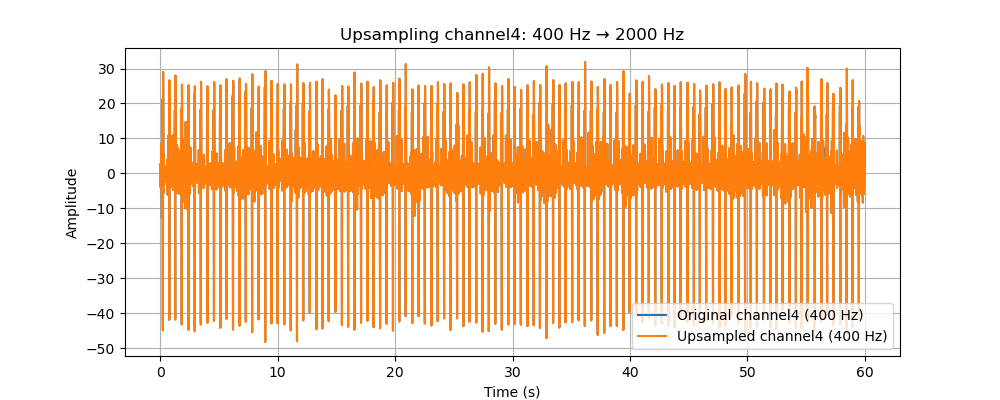

In [15]:
s4 = upsampling(s3, 400, 2000,plot_result=True)
sampling_rate = 2000  # Hz

In [ ]:
from scipy.signal import correlate
from sklearn.decomposition import PCA

def multi_channel_QRS_enhancement(fecg_df:pd.DataFrame,show_plot=False)->pd.DataFrame:
    """
    This function takes a dataframe of FECG and enhances the QRS complex in the signal.
    """
    ecg_data = fecg_df.copy()  

    ecg_data.drop(columns=['time'], inplace=True)

    # Step 1: Normalize the variance of each channel
    normalized_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0)

    # Step 2: Perform PCA on the normalized data
    pca = PCA(n_components=1)
    principal_component = pca.fit_transform(normalized_data)

    # Flip the sign if the principal component is mostly negative
    if np.abs(np.min(principal_component)) > np.abs(np.max(principal_component)):
        principal_component = -principal_component


    # Step 3: Plot the first principal component
    if show_plot:
        plt.figure(figsize=(12, 6))
        # plt.plot(ecg_data, label="ECG Data (3 Channels)", alpha=0.2)
        plt.plot(principal_component, label="First Principal Component (PC1)")
        plt.title("First Principal Component of Multi-Channel ECG Data")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
    return principal_component
    
def find_window_maxima(signal):
    """
    Finds the sample with the maximum absolute amplitude in each 1-second window.

    Args:
        signal (np.array): Input signal.
        fs (int): Sampling frequency in Hz.

    Returns:
        List of indices of the maximum samples in each window.
    """
    window_size = 700  # 700-ms window
    maxima_indices = []

    for i in range(0, len(signal), window_size):
        window = signal[i:i + window_size]
        max_idx = np.argmax(np.abs(window)) + i  # Find index of max absolute amplitude
        maxima_indices.append(max_idx)

    return maxima_indices

def extract_qrs_templates(signal, maxima_indices, fs):
    """
    Extracts QRS templates from the signal based on maxima indices.

    Args:
        signal (np.array): Input signal.
        maxima_indices (list): Indices of maxima in each window.
        fs (int): Sampling frequency in Hz.

    Returns:
        List of QRS templates (np.array) and their corresponding indices.
    """
    template_duration = 0.1  # 100 ms (standard for QRS)
    template_samples = int(template_duration * fs)  # Number of samples in the template
    half_template = template_samples // 2

    templates = []
    template_indices = []

    for idx in maxima_indices:
        start = max(0, idx - half_template)  # Ensure index does not go negative
        end = min(len(signal), idx + half_template)  # Ensure index does not exceed signal length
        
        template = signal[start:end]

        # Ensure the QRS peak is in the middle by shifting indices correctly
        if len(template) < template_samples:
            template = np.pad(template, (0, template_samples - len(template)), 'constant')
        
        templates.append(template)
        template_indices.append((start, end))

    return templates, template_indices

def compute_cross_correlation(signal, templates):
    """
    Computes the cross-correlation between the QRS templates and the signal.

    Args:
        signal (np.array): Input signal.
        templates (list of np.array): List of QRS templates.

    Returns:
        np.array: Averaged cross-correlation vector.
    """
    cross_correlations = []

    for template in templates:
        # Compute cross-correlation
        r = correlate(signal, template, mode="same")

        # Normalize cross-correlation
        template_norm = np.linalg.norm(template) ** 2
        if template_norm > 0:
            r_normalized = r / template_norm
        else:
            r_normalized = r  # Avoid division by zero

        cross_correlations.append(r_normalized)

    # Compute the average cross-correlation over all templates
    avg_cross_correlation = np.mean(cross_correlations, axis=0)

    return avg_cross_correlation

def threshold_cross_correlation(cross_correlation, threshold):
    """
    Applies thresholding to identify QRS candidates from cross-correlation results.

    Args:
        cross_correlation (np.array): Cross-correlation vector.
        threshold (float): Threshold value for QRS detection.

    Returns:
        np.array: Indices where QRS candidates are detected.
    """
    # Find indices where correlation exceeds the threshold
    qrs_candidates = np.where(cross_correlation > threshold)[0]
    return qrs_candidates

def refine_qrs_candidates(qrs_candidates, cross_correlation, fs, min_distance):
    """
    Refines QRS candidates using heuristic rules.

    Args:
        qrs_candidates (np.array): QRS candidate indices.
        cross_correlation (np.array): Cross-correlation vector.
        fs (int): Sampling frequency in Hz.
        min_distance (float): Minimum distance between QRS peaks (in seconds).

    Returns:
        np.array: Refined QRS peak positions.
    """
    refined_positions = []
    prev_index = -np.inf  # Track last valid QRS peak

    for idx in qrs_candidates:
        if idx - prev_index > min_distance * fs:
            refined_positions.append(idx)
            prev_index = idx
        else:
            # Retain the candidate with the highest correlation
            if cross_correlation[idx] > cross_correlation[prev_index]:
                refined_positions[-1] = idx
                prev_index = idx

    return np.array(refined_positions)

In [17]:
s4_pca = multi_channel_QRS_enhancement(s4)

In [18]:
def QRS_detector(pca: pd.DataFrame, sampling_rate=2000,threshold = 0.5, min_distance = 0.5, show_plot=False):
    """
    Detects the QRS complexes from a multi-channel FECG signal.

    Args:
        pca (pd.DataFrame): Multi-channel ECG dataframe (assumes 'time' column is present).
        sampling_rate (int): Sampling frequency (Hz). Default is 400 Hz.
        show_plot (bool): If True, plots QRS detection.
        threshold (float): Threshold for QRS detection.
        min_distance (float): Minimum distance between QRS peaks (in seconds).

    Returns:
        np.array: Detected QRS peak indices.
    """

    # Step 2: Find Maxima in 0.7-Second Windows**
    maxima_indices = find_window_maxima(pca)

    # Step 3: Extract QRS Templates**
    templates, _ = extract_qrs_templates(pca, maxima_indices, sampling_rate)

    # Step 4: Compute Cross-Correlation**
    cross_correlation = compute_cross_correlation(pca, templates)  # Single array now

    # Step 5: Apply Thresholding**
    qrs_candidates = threshold_cross_correlation(cross_correlation, threshold)

    # Step 6: Refine QRS Candidates**
    refined_qrs_positions = refine_qrs_candidates(qrs_candidates, cross_correlation, sampling_rate, min_distance)

    if show_plot:
        time_axis = np.arange(len(pca)) / sampling_rate  # Convert samples to time
        plt.figure(figsize=(12, 5))
        plt.plot(time_axis, pca, label="Enhanced QRS Signal", alpha=0.8)
        plt.scatter(refined_qrs_positions / sampling_rate, pca[refined_qrs_positions],
                    color='red', marker='o', label="Detected QRS Peaks")
        
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.title("QRS Detection")
        plt.legend()
        plt.grid()
        plt.show()

    return refined_qrs_positions

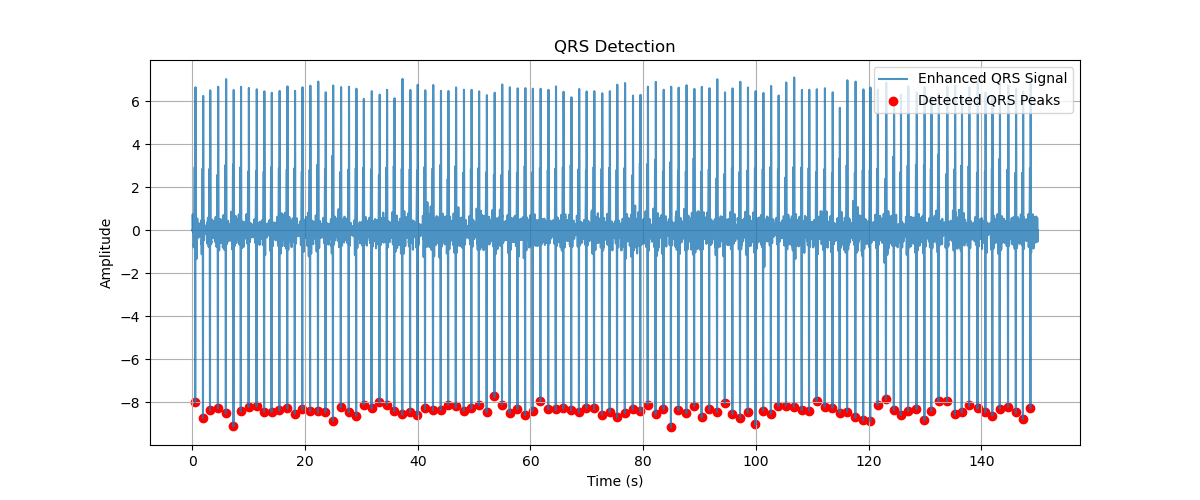

In [19]:
qrs_peaks = QRS_detector(s4_pca,sampling_rate=2000, show_plot=True)

In [21]:
qrs_peaks[:10]

array([  946,  3792,  6589,  9307, 11897, 14660, 17470, 20197, 22826,
       25547])

In [ ]:
s4

In [138]:
# MECG cancellation: prepare windows and implement subtraction loop

def extract_mecg_windows(signal, qrs_peaks, fs, pre_qrs=0.25, post_qrs=0.45):
    """
    Extracts MECG windows around each QRS peak.

    Args:
        signal (np.array): Enhanced ECG signal.
        qrs_peaks (np.array): Detected QRS indices.
        fs (int): Sampling frequency in Hz.
        pre_qrs (float): Seconds before the QRS to start the window.
        post_qrs (float): Seconds after the QRS to end the window.

    Returns:
        List of MECG window arrays and their original indices.
    """
    window_size = int((pre_qrs + post_qrs) * fs)
    half_pre = int(pre_qrs * fs)
    windows = []
    indices = []

    for peak in qrs_peaks:
        start = peak - half_pre
        if start < 0:
            start = 0
        end = start + window_size
        if end > len(signal):
            end = len(signal)
        windows.append(signal[start:end])
        indices.append((start, end))

    return windows, indices

def compute_least_min_square(mu_P, mu_QRS, mu_T, m):
    """
    Constructs M using zero-padded block columns for mu_P, mu_QRS, and mu_T,
    Solves the least-squares problem to estimate m_hat (estimated MECG).
    """
    # Flatten all inputs to 1D
    # mu_P = mu_P.ravel()
    # mu_QRS = mu_QRS.ravel()
    # mu_T = mu_T.ravel()
    # m = m.ravel()


    # Determine the lengths
    len_P = len(mu_P)
    len_QRS = len(mu_QRS)
    len_T = len(mu_T)

    # Pad mu_P: on bottom
    col_P = np.concatenate([mu_P, np.zeros(len_QRS + len_T)])

    # Pad mu_QRS: top and bottom
    col_QRS = np.concatenate([np.zeros(len_P), mu_QRS, np.zeros(len_T)])

    # Pad mu_T: on top
    col_T = np.concatenate([np.zeros(len_P + len_QRS), mu_T])

    # Stack to form M matrix: shape (total_len, 3)
    M = np.column_stack([col_P, col_QRS, col_T])

    # Solve least-squares: a = (MᵀM)⁻¹ Mᵀ m
    MTM = M.T @ M
    MTm = M.T @ m
    a = np.linalg.pinv(MTM) @ MTm
    m_hat = M @ a
    # print(f"scaling factors: {a}")

    return m_hat 


def mecg_cancellation(ecg_df,qrs_peaks, fs, N=10):
    """
    Applies MECG cancellation using scaling of P, QRS, T wave and subtracts only where m̂ is defined.
    """
    cleaned_signal = ecg_df.copy()
    # Extract MECG windows
    for column in cleaned_signal.columns:
        if column == 'time':
            continue
        signal = cleaned_signal[column].values
        windows, window_indices = extract_mecg_windows(signal,qrs_peaks,fs)
        for i in range(N, len(windows)):
            m = windows[i]
            mu = np.mean(windows[i - N:i], axis=0)

            # Extract P, QRS, T segments
            # Assuming fs = 2000 Hz, adjust indices accordingly
            # P: 0.25s before QRS
            # QRS: 0.05s before and after QRS
            # T: 0.05s after QRS and 0.45s after QRS
            qrs_center = int(0.25 * fs)

            # QRS = R ± 0.05s
            qrs_start = qrs_center - int(0.05 * fs)
            qrs_end   = qrs_center + int(0.05 * fs)

            # P wave: 0.20s before QRS window
            p_start = qrs_start - int(0.20 * fs)
            p_end   = qrs_start

            # T wave: 0.40s after QRS window
            t_start = qrs_end
            t_end   = qrs_end + int(0.40 * fs)

            # From averaged window (μ)
            mu_P   = mu[p_start:p_end]
            mu_QRS = mu[qrs_start:qrs_end]
            mu_T   = mu[t_start:t_end]

            # From current window (m)
            m_P   = m[p_start:p_end]
            m_QRS = m[qrs_start:qrs_end]
            m_T   = m[t_start:t_end]

            m_full = np.concatenate([m_P, m_QRS, m_T])

            # Use least-min-square estimator
            m_hat = compute_least_min_square(mu_P, mu_QRS, mu_T, m_full)

            # Subtract m_hat from the original signal
            start, end = window_indices[i]
            signal[start:end] -= m_hat

        # Update the cleaned signal in the dataframe
        cleaned_signal[column] = signal


    return cleaned_signal



m shape: (1400,)
mu shape: (1400,)
qrs_center: 500
mu_P shape: (400,)
mu_QRS shape: (200,)
mu_T shape: (800,)
m_full shape: (1400,)
m_hat shape: (1400,)


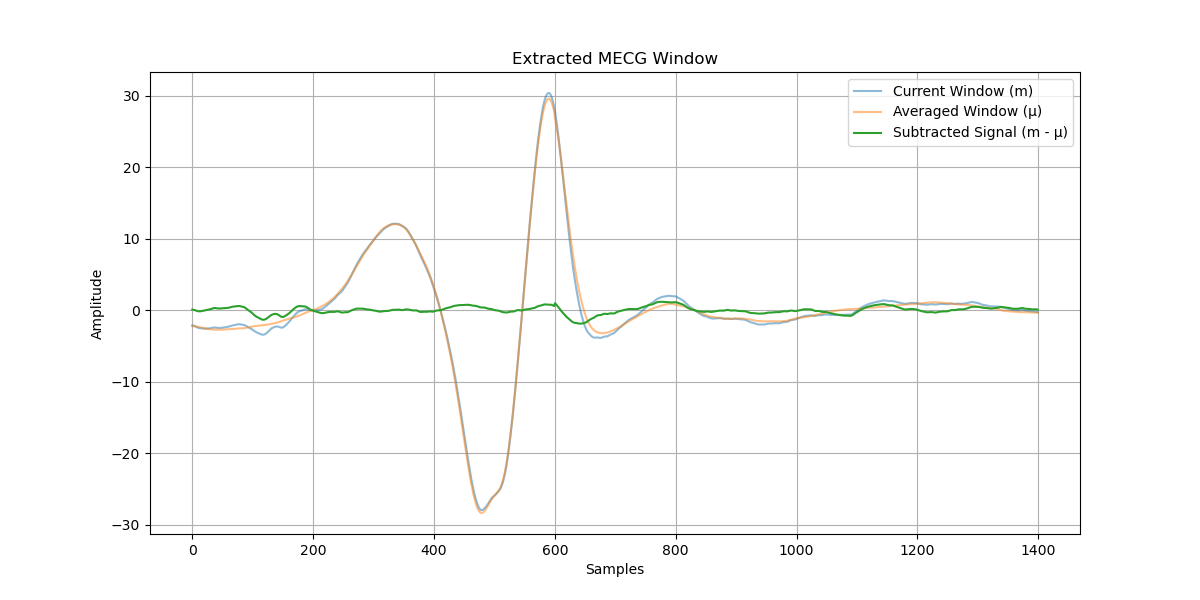

In [120]:
windows_test , windows_test_indices = extract_mecg_windows(s4.channel3,qrs_peaks,2000)
m = windows_test[10]
mu = np.mean(windows_test[0:10], axis=0).ravel()
print(f"m shape: {m.shape}")
print(f"mu shape: {mu.shape}")
# Extract P, QRS, T segments
fs = 2000 #Hz, adjust indices accordingly
# P: 0.25s before QRS
# QRS: 0.05s before and after QRS
# T: 0.05s after QRS and 0.45s after QRS
qrs_center = int(0.25 * fs)
print(f"qrs_center: {qrs_center}")
# QRS = R ± 0.05s
qrs_start = qrs_center - int(0.05 * fs)
qrs_end   = qrs_center + int(0.05 * fs)

            # P wave: 0.20s before QRS window
p_start = qrs_start - int(0.20 * fs)
p_end   = qrs_start

            # T wave: 0.40s after QRS window
t_start = qrs_end
t_end   = qrs_end + int(0.40 * fs)

            # From averaged window (μ)
mu_P   = mu[p_start:p_end]
print(f"mu_P shape: {mu_P.shape}")
mu_QRS = mu[qrs_start:qrs_end]
print(f"mu_QRS shape: {mu_QRS.shape}")
mu_T   = mu[t_start:t_end]
print(f"mu_T shape: {mu_T.shape}")

            # From current window (m)
m_P   = m[p_start:p_end]
m_QRS = m[qrs_start:qrs_end]
m_T   = m[t_start:t_end]

m_full = np.concatenate([m_P, m_QRS, m_T])
print(f"m_full shape: {m_full.shape}")
# Use least-min-square estimator
m_hat = compute_least_min_square(mu_P, mu_QRS, mu_T, m_full)
print(f"m_hat shape: {m_hat.shape}")
# Subtract m_hat from the original signal
start, end = windows_test_indices[10]
signal = s4.channel3.values.copy()
signal[start:end] -= m_hat
# Plot the original signal
resul_signal = signal[start:end]
# Plot the first window
plt.figure(figsize=(12, 6))
plt.plot(m_full, label="Current Window (m)", alpha=0.5)
plt.plot(m_hat, label="Averaged Window (μ)", alpha=0.5)
plt.plot(resul_signal, label="Subtracted Signal (m - μ)")
plt.title("Extracted MECG Window")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

In [139]:
s5 = mecg_cancellation(s4,qrs_peaks,sampling_rate)

In [ ]:
def plot_mecg_removal_example(enhanced_signal,cleaned_signal, qrs_peaks, fs, i=10):
    """
    Visualizes one example of MECG cancellation by comparing the original and cleaned signals
    in a window around a selected QRS peak.
    
    Args:
        enhanced_signal (np.ndarray): Original signal before subtraction
        cleaned_signal (np.ndarray): Signal after MECG subtraction
        qrs_peaks (np.ndarray): Detected QRS peaks
        fs (int): Sampling frequency
        i (int): Index of QRS peak to visualize
    """
    pre_qrs = int(0.25 * fs)
    post_qrs = int(0.45 * fs)
    center = qrs_peaks[i]
    start = center - pre_qrs
    end = center + post_qrs

    t = np.arange(start, end) / fs
    plt.figure(figsize=(12, 4))
    plt.plot(t, enhanced_signal[start:end], label="Before Cancellation (Enhanced)", alpha=0.6)
    plt.plot(t, cleaned_signal[start:end], label="After Cancellation (Cleaned)")
    # plt.axvline(center / fs, color='r', linestyle='--', label='QRS Center')
    plt.title(f"MECG Cancellation Example (QRS index: {i})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

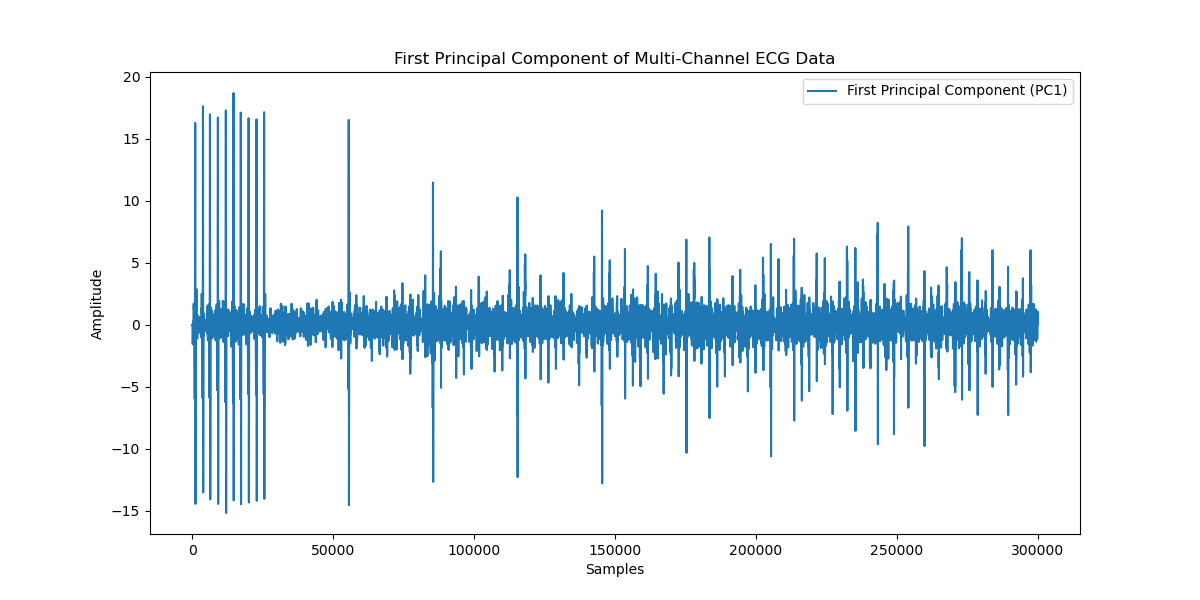

In [146]:
s5_pca = multi_channel_QRS_enhancement(s5,show_plot=True)


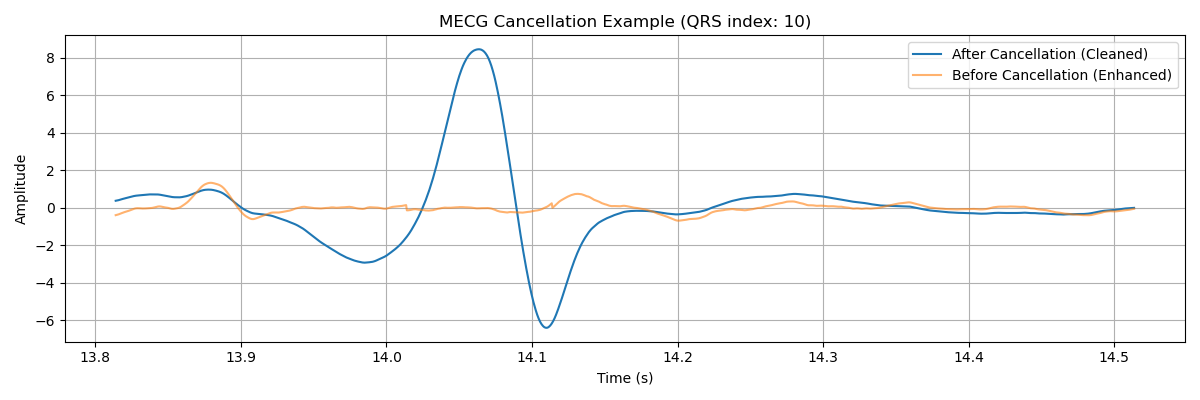

In [147]:
plot_mecg_removal_example(s4_pca,s5_pca,qrs_peaks,sampling_rate,i=10)

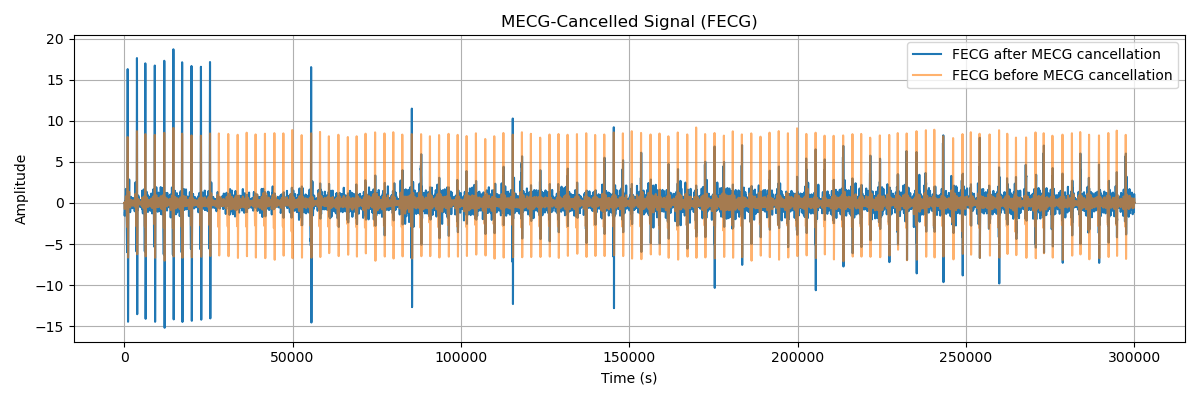

In [148]:
time = np.arange(len(s5)) / sampling_rate

plt.figure(figsize=(12, 4))
plt.plot(s5_pca, label="FECG after MECG cancellation")
plt.plot(s4_pca, label="FECG before MECG cancellation", alpha=0.6)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("MECG-Cancelled Signal (FECG)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


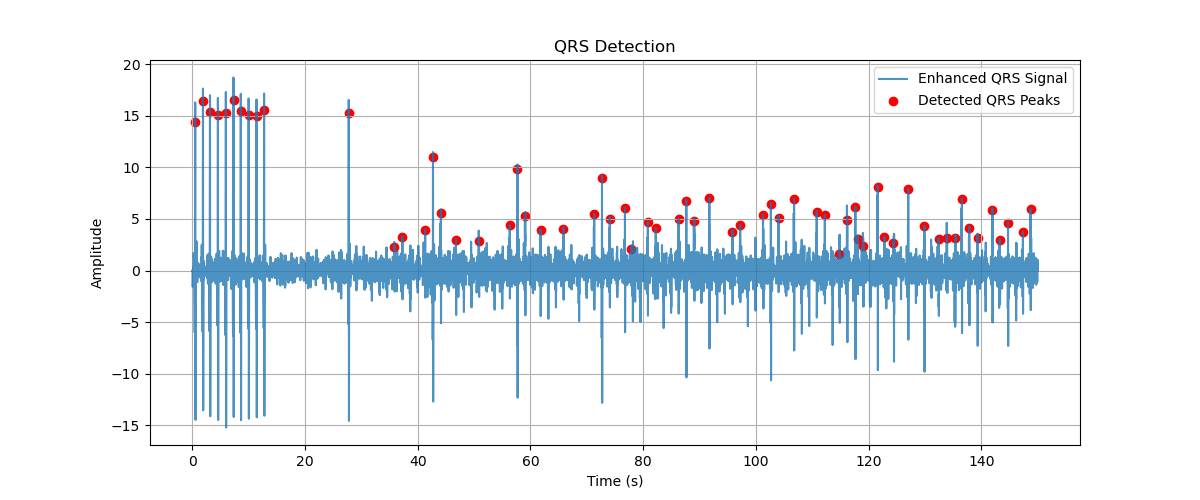

In [155]:
qrs_peaks_fetal = QRS_detector(s5_pca,sampling_rate=2000, show_plot=True,threshold=0.2, min_distance=0.25)

In [163]:
def average_fecg_complex(cleaned_ecg_df, fetal_qrs_peaks, fs, window_sec=0.6):
    """
    Computes the average FECG complex for each channel over fetal QRS peaks.
    
    Args:
        cleaned_ecg_df (pd.DataFrame): MECG-cancelled multi-channel ECG.
        fetal_qrs_peaks (np.array): Detected fetal QRS indices.
        fs (int): Sampling frequency in Hz.
        window_sec (float): Total window length in seconds (e.g., 0.6s).
    
    Returns:
        dict: {channel_name: avg_fecg_segment (np.array)}
    """
    window_len = int(window_sec * fs)
    half_len = window_len // 2

    avg_complexes = pd.DataFrame()
    # Initialize a dictionary to store average complexes for each channel
    

    for col in cleaned_ecg_df.columns:
        if col == "time":
            continue

        segments = []
        signal = cleaned_ecg_df[col].values

        for peak in fetal_qrs_peaks:
            start = peak - half_len
            end = peak + half_len

            if start >= 0 and end < len(signal):
                segments.append(signal[start:end])

        if segments:
            avg_complex = np.mean(segments, axis=0)
            avg_complexes[col] = avg_complex

    return avg_complexes


In [170]:
average_fecg_complexes = average_fecg_complex(s5, qrs_peaks_fetal, fs=2000, window_sec=0.6)

In [171]:
average_fecg_complexes.head()


,channel1,channel2,channel3,channel4
0,1.205542,-2.983200,-0.809272,-1.220507
1,1.232535,-3.003956,-0.821287,-1.244990
2,1.260500,-3.023510,-0.833192,-1.268641
3,1.289590,-3.042450,-0.845469,-1.292029
4,1.319365,-3.060904,-0.858327,-1.315556


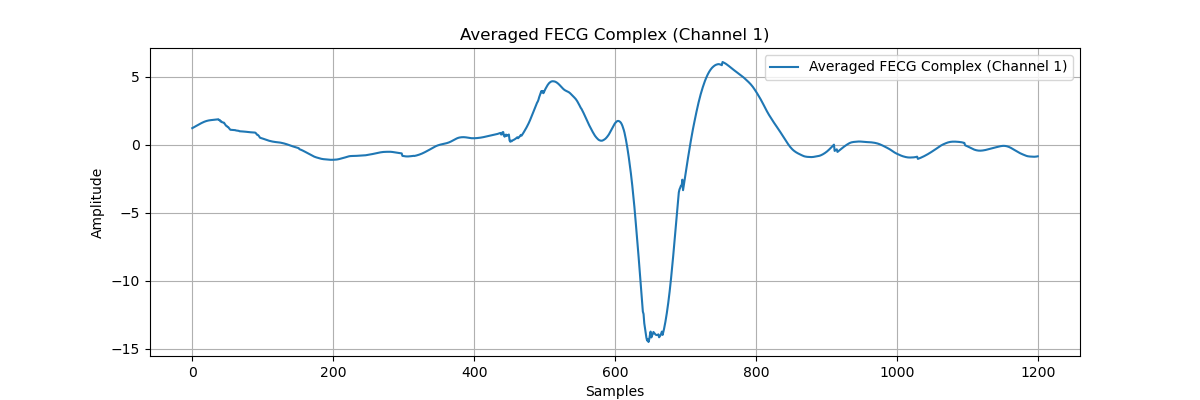

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(average_fecg_complexes.channel1, label="Averaged FECG Complex (Channel 1)")
plt.title("Averaged FECG Complex (Channel 1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()


In [173]:
def compute_final_avg_fecg(avg_complexes):
    return np.mean(avg_complexes, axis=1).values


In [174]:
final_avg_fecg = compute_final_avg_fecg(average_fecg_complexes)

In [175]:
final_avg_fecg.shape

(1200,)

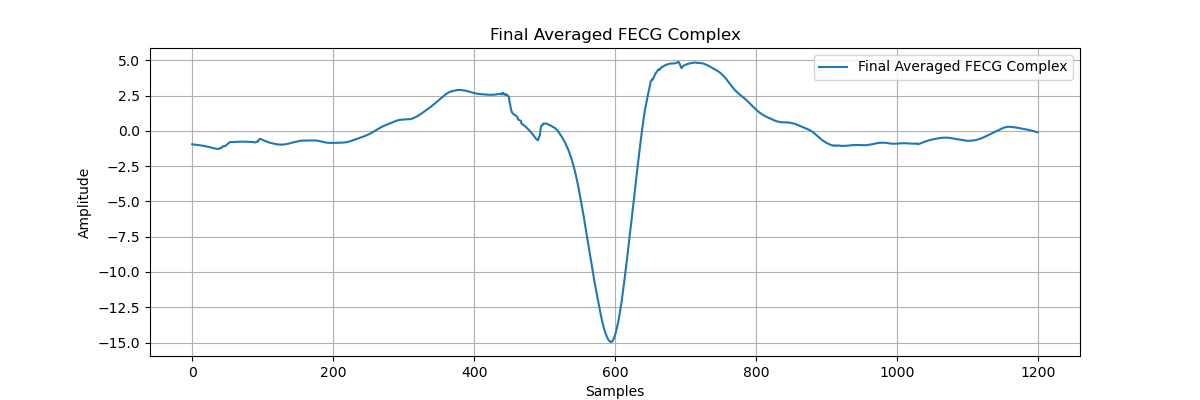

In [176]:
plt.figure(figsize=(12, 4))
plt.plot(final_avg_fecg, label="Final Averaged FECG Complex")
plt.title("Final Averaged FECG Complex")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()